<a id = 'top'></a>
# Void Finding

By Mairead Heiger for AST1430: Cosmology at the University of Toronto

- ### [Methods](#meth)
    - [`Interpolation`](#interp)
    - [`Smoothing`](#smooth)
    - [`Thresholding`](#thresh)
    - [`Next steps`](#next)
- ### [Test Data](#toy)
    - #### [One void](#one)
        - [Interpolation](#interpone)
            - [`Density maps`](#densone)
        - [Thresholding](#threshone)
    - #### [Multiple voids](#multi)
        - [Interpolation](#interpmulti)
            - [`Density maps`](#densmulti)
        - [Thresholding](#threshmulti)
- ### [SDSS Data](#sdss)
    - [Interpolation](#interpsdss)
        - [`Density map`](#denssdss)
    - [Thresholding](#threshsdss)

<a id = 'meth'></a>

## Methods

The general steps in the void finding algorithm are as follows:
    
    Given input data points D = {D_x, D_y} = {(x_1, y_1), (x_2, y_2)...(x_n, y_n)}, calculate the Voronoi diagram V.
  
    Calculate the density (rho = 1 / area_C) at every point in D with cell C in V.
    
    Given an MxM grid, interpolate the density at every point p = (i,j).
        If interpolation method is nearest neighbor:
            density_ij = rho(closest point in D to p)
        If interpolation method is distance weighted:
            choose _k_
            density_ij = mean(rho(closest _k_ points in D to p))
        If interpolation method is Voronoi neighbors:
            Insert p into V with cell C_p.
            For all n cells in V:
                If C_p and and C_n share a wall:
                    point D_n in cell C_n is a neighbor of p
            density_ij = mean(density of neighbors)
    
    Smooth density with Gaussian blur.
    
    Calculate a threshold density value.
    
    For each grid point (i,j) in density:
        If density_ij < threshold:
            (i,j) is a void.
        Else:
            (i,j) is not a void.
            
            
<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

<a id = 'interp'></a>

### 3 interpolation methods

The data points need to be converted into a density map in order to find the voids. This requires interpolation between the points, which is done using the Voronoi diagram of the data points.

The biggest challenge was the (mis)identification of "trivial" voids. There is no set definition of what constitutes a void: how empty is empty enough? Do they have to be a certain size? Without specifying such cut-offs, different methods of interpolation and binarization yielded more voids than others. Within the test data, they all find the actual intended void to some extent, and some find the space between points as voids and others don't. I tried 3 methods of increasing complexity with varying success.

1. #### Simplest: Nearest neighbors. 
    Assign each grid point the same density as the data point closest to it. Since a Voronoi diagram is constructed such that all points within a Voronoi cell are closer to the 'seed' data point than any other, this method produces a density map that is a poorly resolved Voronoi diagram. This method identifies the void but also identifies a considerable number of 'trivial' voids that are essentially noise in the density map. It improves considerably after smoothing.
    
2. #### Moderate: Distance weighting. 
    Assign each grid point the average density of the _k_ closest points. The density map is smoother with this method than with the nearest neighbor interpolation, but it struggles at the edges of voids. Grid points that are squarely in the void but at the edges pull their density primarily from data in high density areas outside of the void, artificially raising their density. It essentially washes out the density map and makes it harder to identify the true size of the void. It's quite ineffective overall and not very functional.
    
3. #### Most complex: Voronoi Neighbors.
    Assign each grid point the average density of its Voronoi neighbors. In a Voronoi diagram, a seed point's neighbors are the points whose cells border its own. In this case, the Voronoi neighbors of the grid points are the original data points whose cells border the grid point if the grid point is included in the Voronoi diagram. This method is based on natural neighbor interpolation, which several void finding algorithms use, but is much simpler. Despite being much simpler, it's still very slow because it recalculates a Voronoi diagram for every grid point and then searches through the entire diagram for neighbors. Regardless, it seems to be the most effective at producing a smooth density map and identifying large voids without picking up as much noise. After smoothing, however, the performance of the nearest neighbor method is very similar.
    
With one void, the nearest neighbor method improves considerably with Gaussian smoothing, as do the other two (but not as much). Even with blurring, the distance weighted method is still not very good. Blurring also washes out small voids, which is a particular problem with the Voronoi neighbors method with a coarse grid.

<a id = 'smooth'></a>

### Smoothing

After interpolation, the density map is smoothed. Depending on the interpolation method, the resulting map is very noisy, which Gaussian smoothing/blurring reduces. The noise is liable to be detected as a void, so smoothing helps minimize detection of trivial voids and non-voids without sacrificing the detection of larger voids, since they are on a larger scale. There's a risk that it will wash small voids out completely, however. Smaller scale smoothing (smaller $\sigma$) is less liable to do so. Smoothing at the same scale would not be appropriate for every dataset, so the algorithm returns results both with and without smoothing, and can always be applied with more fine tuning on the unsmoothed result. 

Gaussian smoothing is done with a built-in sci-kit filter: https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.gaussian


<a id = 'thresh'></a>

### Thresholding

After smoothing, the final density map is ready for a threshold analysis! This is a binarization: all points with densities below a certain threshold are voids; above the threshold, they are not voids. As with the interpolation methods, the threshold changes what is considered a void and what isn't. Some methods are very liable to find many trivial voids, or to interpret noise as voids. The binarization is calculated using ski-kit filters as well: https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html.

The final result is a black and white image, where black areas are voids.

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

<a id ='next'><a>

### Next steps

This algorithm, though simple, does separate areas in a plane with no galaxies/points from areas with them, with some margin. Overall, for large voids, there isn't (by eye) a large difference between the smooothed nearest neighbor method and the Voronoi neighbor method. The distance weighted method never performs well, regardless of the size, shape, or number of voids, how much smoothing is or isn't applied, or how coarse/fine the grid is (although a coarse grid actually does better). It's included in all tests, but ultimately, it's not functional. For the test data with smaller voids, a finely sampled grid is necessary to avoid washing out the small voids, and the Voronoi neighbor method better captures the true shape of the voids. Without knowing what should or shouldn't count as a void in real data, the Voronoi neighbor method is likely the more accurate of the two at distinguishing voids and their shape, but it's much more computationally intensive. Searching the entire grid for neighbors is prohibitive, especially for a large dataset or a very fine grid. It could absolutely be coded more efficiently (only searching nearby for neighbors, inserting multiple points far away from each other and searching once for all of them, etc.), but in its current form, it's slow. The smoothed nearest neighbor method is a good compromise between efficiency and accuracy.

The thresholding method is currently a case-by-case determination, but two methods stand out. Otsu binarization uses a the threshold that maximizes variance between background (void) and foreground. It is the threshold often used in image processing as a step in a watershed algorithm, which several void finders use. It works well on the test data and is shown below. Mean thresholding, where the threshold is the mean value of the image, identifies voids well in test data, but captures noise. However, because we cannot definitively say what is as a void and what is noise/non-void space between structures is, identifying more trivial voids may be preferable to missing them, and mean thresholding is very simple.

Going forward, this algorithm could be applied to larger real datasets. In the simplest test case done here, a void has a true density of zero (no galaxies/points). However, from observational data, we know that voids are not truly empty--a more physical void would be better described as having an extremely low density (whatever 'extreme' may be). This algorithm is flexible enough to still apply, because although the true (test) data assumes that a void has zero density, that assumption is not passed on to the algorithm. It would separate non-zero, low density areas from higher density areas, and does not require prior selection of the characteristics of the void. As with other void finding algorithms, it could be applied to datasets of galaxies at varying redshifts to analyze the evolution of structure over time. It could also be used to analyze the size of voids and compare them to predictions for different combinations of cosmological parameters, notably dark matter and energy density, and theories of modified gravity.

Currently, the best the algorithm can do is identify 'void' and 'not void' in broad strokes, but the cosmic web is more complex than just those two structures. A binarization will always return 'void'/'not void', but its accuracy is in part due to the assumption that the galaxies are points and the density of space is related only to how close points are to other points (which is reflected in the area of the Voronoi cells). Although the area of the cell is strongly related to the local physical density, it is not a mass density and has flaws. For example, if a very massive galaxy is in a filament rather than a cluster, this algorithm may misrepresent the size of the void. A true mass density (where the area is based on the size of the galaxy, not the Voronoi cell, or some combination of the two) has clear physical meaning and might account in part for the fact that the cosmic web is comprised of filamentary and wall-like structures as well as clusters and voids.

The algorithm could also be improved, likely considerably, by a better thresholding method. Some exisiting void finding algorithms use watershed methods, for which binarization is one step in the final processing. Another good option is automatic thresholding. Automatic thresholding calculates a threshold from an image, separates it into foreground/background, then calculates the threshold from the foreground/background individually, and, if the average of the two is below a chosen value, that threshold is applied to the original image, and the process repeats. There are also some other buggy things about the way the code is written--right now, the algorithm considers the input data to be a square, so the non-square SDSS data has a unphysically low density border that changes the threshold value.

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

## The actual code!

In [1]:
# imports
import os
import numpy as np
from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, distance
from astropy.io import ascii
import skimage.filters as filters

# import home brewed functions
import void_funcs as voids
voids.test('Did it work?')

Loaded correctly


In [2]:
# plotting pleasantries
plt.style.use("seaborn-colorblind")
mpl.rcParams['figure.figsize'] = 8.0,8.0
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['figure.titlesize'] = 25

In [3]:
rng = np.random.default_rng(seed=42) # seed the generator so that re-running the code produces the same results

<a id = 'toy'></a>

## Test Data

<a id = 'one'></a>

Test the void finding algorithm on randomly generated points with a single obvious void

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

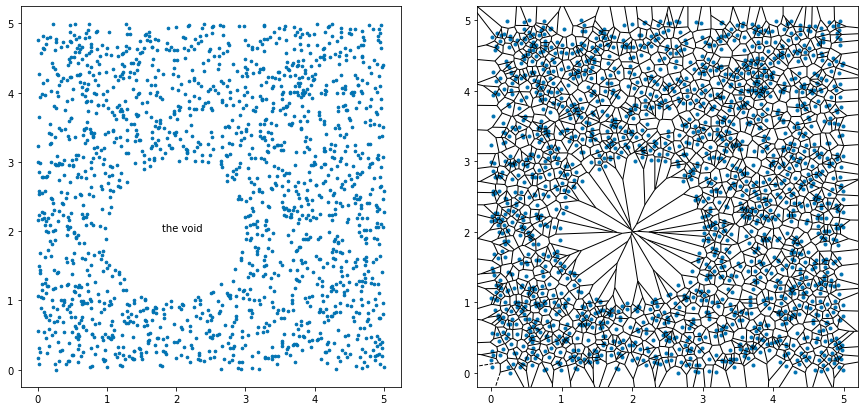

In [4]:
# generate random test points with an obvious circular void to find

points_o = rng.uniform(0, 5, (2000,2)) # generate 2,000 points uniformly over the domain and range [0, 5]

x0, y0, radius = 2, 2, 1 # define a circle that will act as the "void"
r_o = np.sqrt((points_o[:,0]- x0)**2 + (points_o[:,1] - y0)**2)

outside_o = r_o > radius # keep points outside of the circle

x_o,y_o = points_o[:,0][outside_o],points_o[:,1][outside_o] # for bookeeping, define x and y 
points_o = points_o[outside_o] # redefine the points accordingly

# plot a scatter plot of the test points and their Voronoi diagram
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,7))

ax1.scatter(x_o,y_o, s = 7)
voronoi_plot_2d(Voronoi(points_o), ax=ax2, point_size=6, show_points=True, show_vertices=False)

ax1.annotate("the void", (x0-0.2,y0))
plt.xlim(min(x_o-0.2), max(x_o+0.2))
plt.ylim(min(y_o-0.2), max(y_o+0.2))
plt.show()

<a id = 'interpone'></a>
#### Calculate the density maps

_If you re-run it, just a heads up that it's slow! The Voronoi neighbor interpolation is crazy inefficient (takes 20+ mins on my laptop for the 100x100 grid...). A coarse 20x20 grid captures the very broad strokes and takes a more reasonable amount of time)_

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

In [5]:
# calculate the density maps for the 3 interpolation methods, both blurred and unblurred
    # change 'all' to 'NN', 'DW', or 'VN' for just one method
blurred_o, unblurred_o, ixo, iyo = voids.interpolater(points_o, 'all', grid = 100)

<a id='densone'></a>

#### Plot the density maps

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

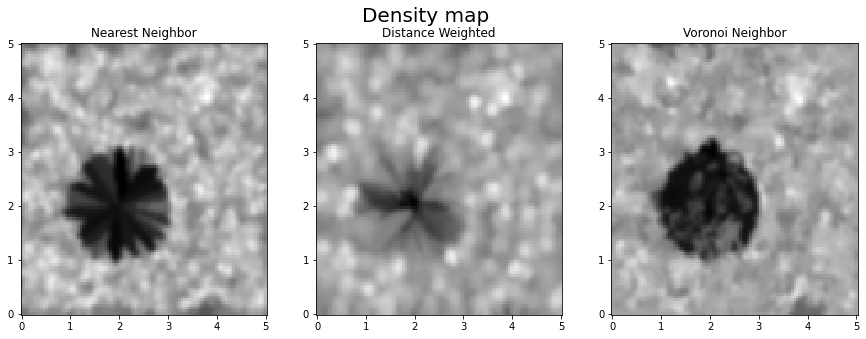

In [6]:
# the final density maps for each interpolation method

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))

ax1.pcolormesh(ixo,iyo,blurred_o[0],cmap='gray'); ax1.set_title("Nearest Neighbor")
ax2.pcolormesh(ixo,iyo,blurred_o[1],cmap='gray'); ax2.set_title("Distance Weighted")
ax3.pcolormesh(ixo,iyo,blurred_o[2],cmap='gray'); ax3.set_title("Voronoi Neighbor")

fig.suptitle("Density map",fontsize = 20)
plt.show()

<a id='threshone'></a>

#### Thresholding 


<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

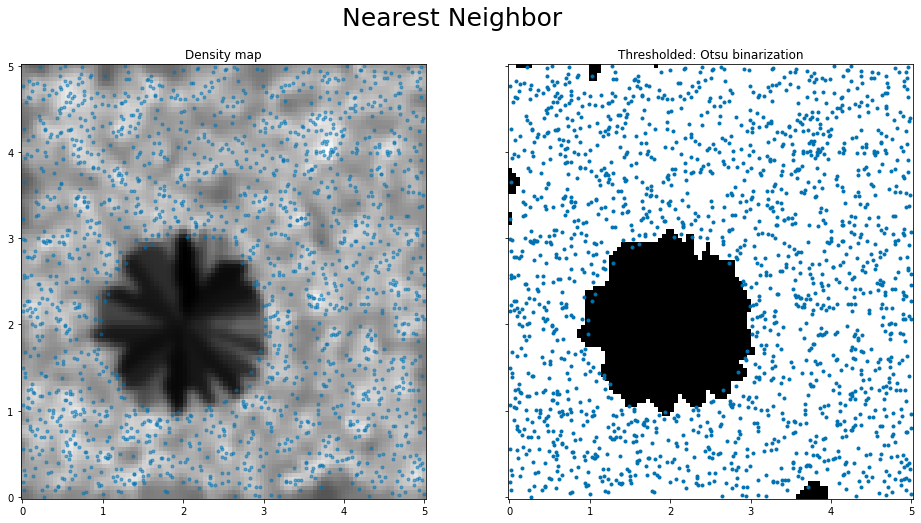

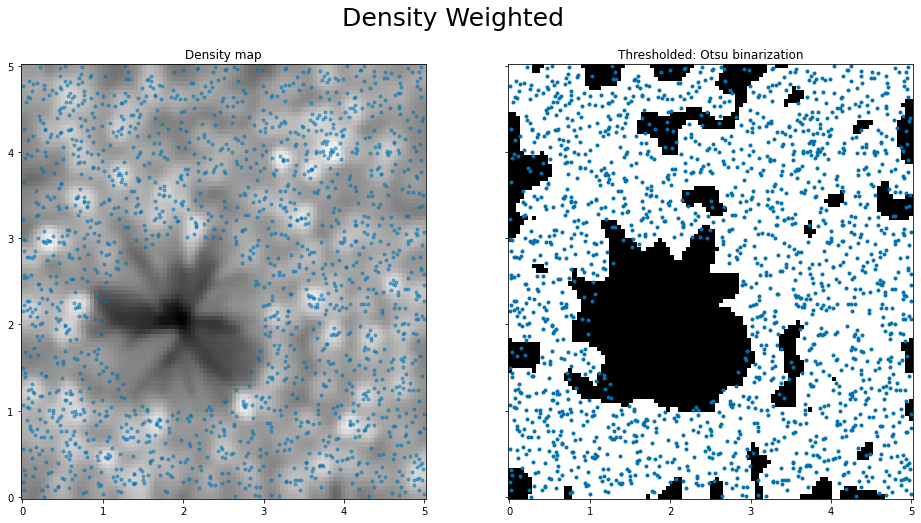

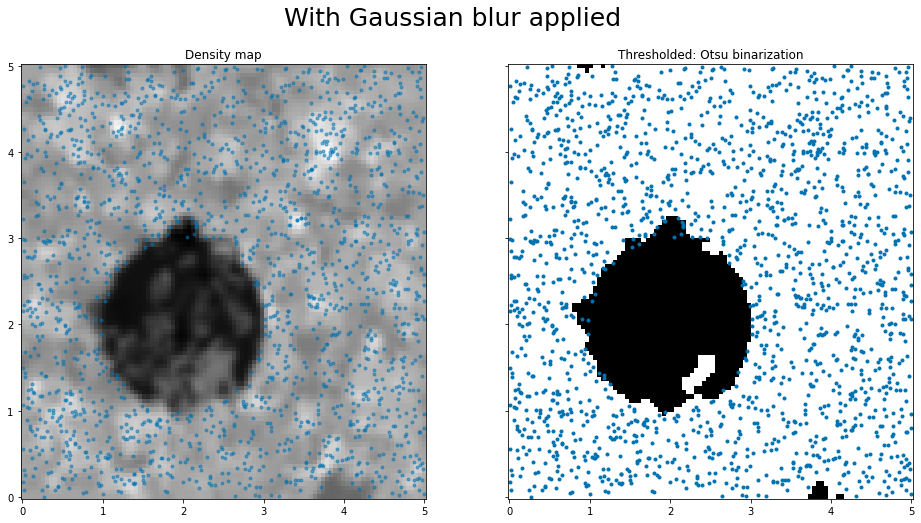

In [7]:
for image, title in zip(blurred_o,["Nearest Neighbor","Density Weighted","Voronoi Neighbor"]):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharex=True,sharey=True)
    fig.suptitle(title)
    
    ax1.pcolormesh(ixo, iyo, image,cmap='gray')
    ax1.plot(x_o,y_o,'.',alpha = 0.5)
    ax1.set_title('Density map')

    ax2.pcolormesh(ixo, iyo, binary, cmap='gray')
    ax2.plot(x_o,y_o,'.')
    ax2.set_title('Thresholded: Otsu binarization')

fig.suptitle("With Gaussian blur applied")
plt.show()

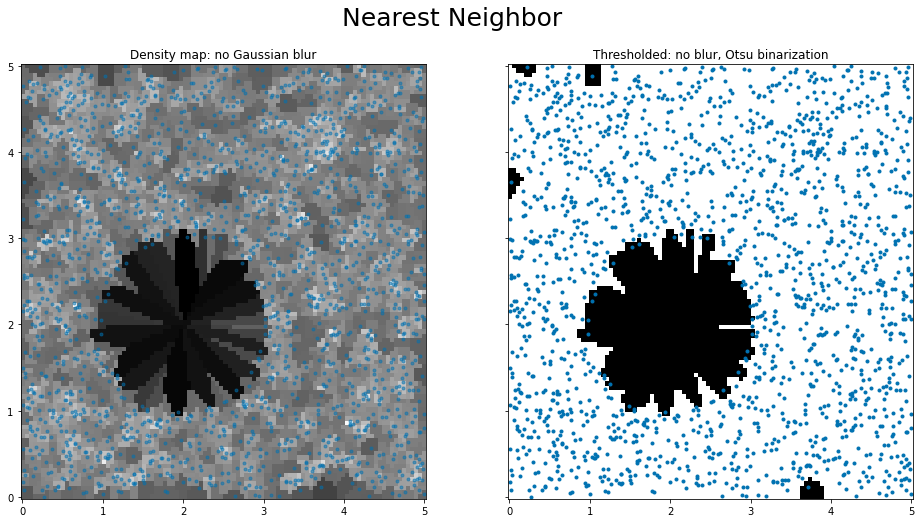

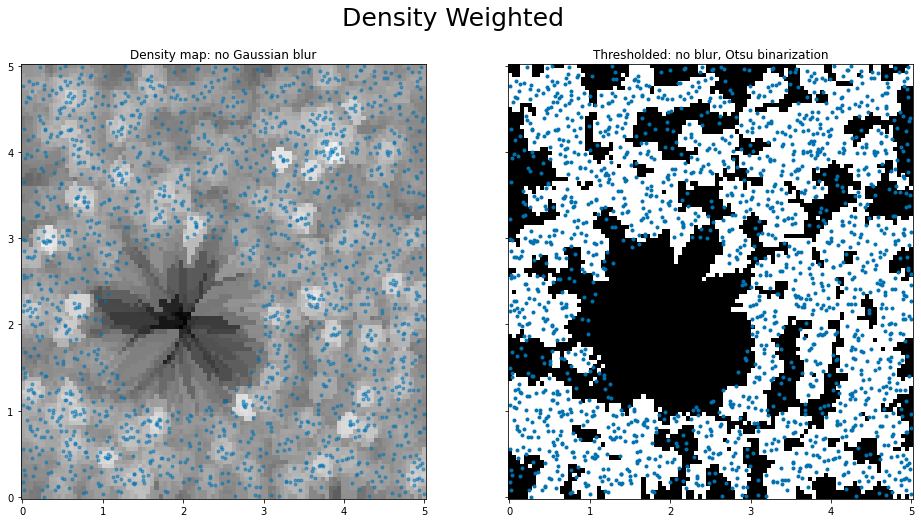

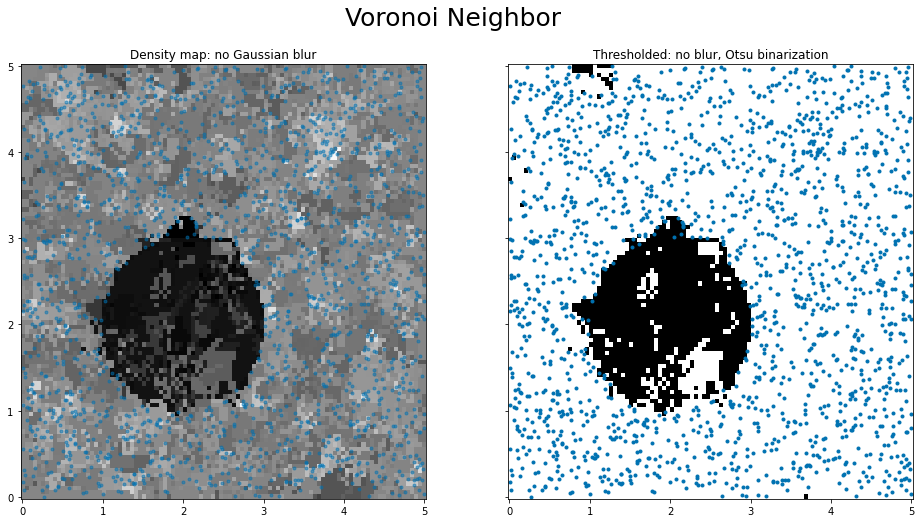

In [8]:
for image, title in zip(unblurred_o,["Nearest Neighbor","Density Weighted","Voronoi Neighbor"]):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharex=True,sharey=True)
    fig.suptitle(title)
    
    ax1.pcolormesh(ixo, iyo, image,cmap='gray')
    ax1.plot(x_o,y_o,'.',alpha = 0.5)
    ax1.set_title('Density map: no Gaussian blur')

    ax2.pcolormesh(ixo, iyo, binary, cmap='gray')
    ax2.plot(x_o,y_o,'.')
    ax2.set_title('Thresholded: no blur, Otsu binarization')

plt.show()

##### Compare thresholds

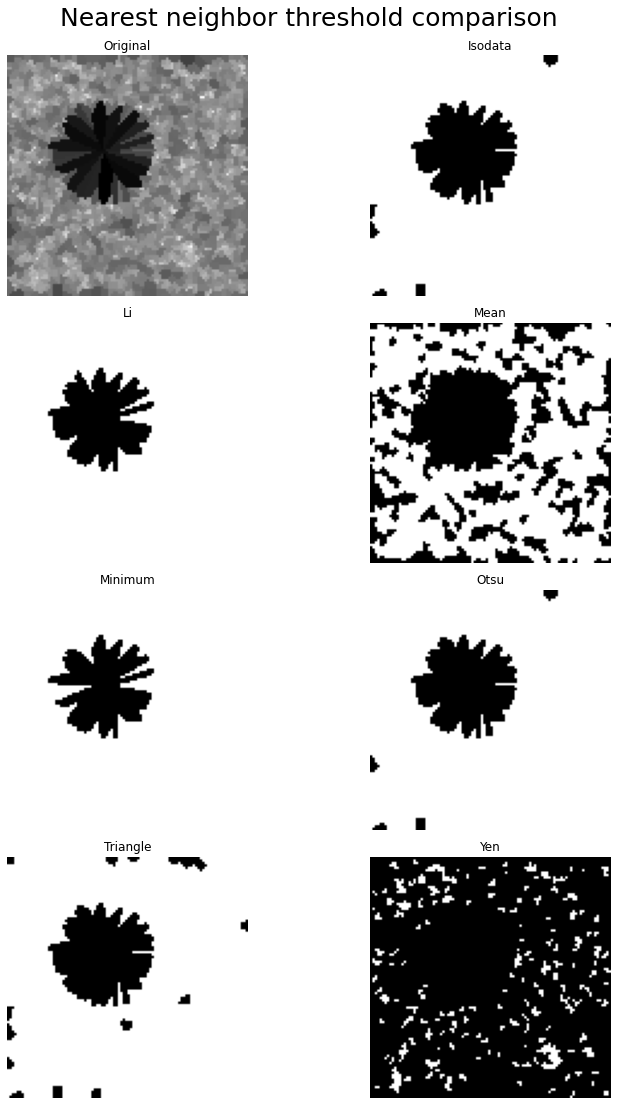

In [9]:
img = unblurred_o[0]

fig, ax = filters.try_all_threshold(img, figsize=(12, 15), verbose=False)

fig.suptitle("Nearest neighbor threshold comparison",y=1.02)
plt.show()

<a id='multi'><a>

### Multiple voids

Test the code now on toy data with multiple smaller voids. 
    
<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

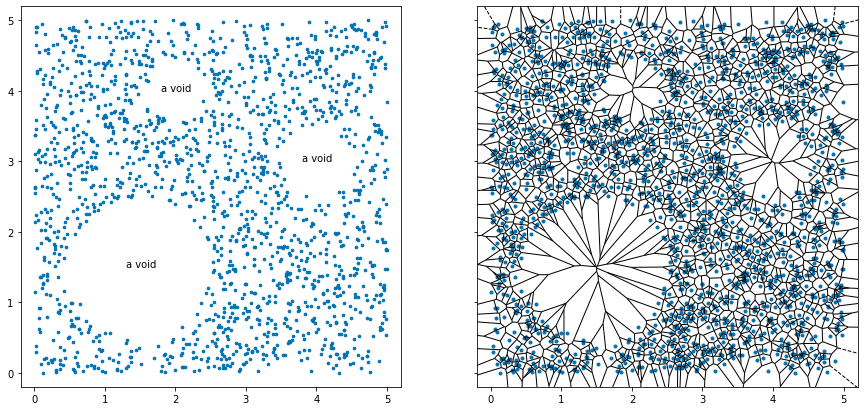

In [10]:
# generate random test points with 3 circular voids to find

points_m = rng.uniform(0, 5, (2000,2)) # generate 2,000 points uniformly over the domain and range [0, 5]

x1, y1, radius1 = 1.5, 1.5, 1 # define a circle that will act as the "void"
x2, y2, radius2 = 4, 3, 0.5 
x3, y3, radius3 = 2, 4, 0.4
r1, r2, r3 = np.sqrt((points_m[:,0]- x1)**2 + (points_m[:,1] - y1)**2), np.sqrt((points_m[:,0]- x2)**2 + (points_m[:,1] - y2)**2), np.sqrt((points_m[:,0]- x3)**2 + (points_m[:,1] - y3)**2)

out_m = (r1 > radius1)&(r2 > radius2)&(r3 > radius3) # keep points outside of the circles

x_m,y_m = points_m[:,0][out_m],points_m[:,1][out_m] # for bookeeping, define x and y 
points_m = points_m[out_m] # redefine the points accordingly

# plot the test points
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,7),sharex=True,sharey=True)

ax1.annotate("a void", (x1-0.2,y1)); ax1.annotate("a void", (x2-0.2,y2)); ax1.annotate("a void", (x3-0.2,y3))
ax1.scatter(x_m,y_m, s = 7)
voronoi_plot_2d(Voronoi(points_m), ax=ax2, point_size=6, show_points=True, show_vertices=False)

ax1.set_xlim(min(x_m-0.2), max(x_m+0.2))
ax1.set_ylim(min(y_m-0.2), max(y_m+0.2))
plt.show()

<a id = 'interpmulti'></a>

In [11]:
blurred_m, unblurred_m, ixm, iym = voids.interpolater(points_m, 'all', grid = 100)

<a id = 'densmulti'></a>

#### Density maps

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

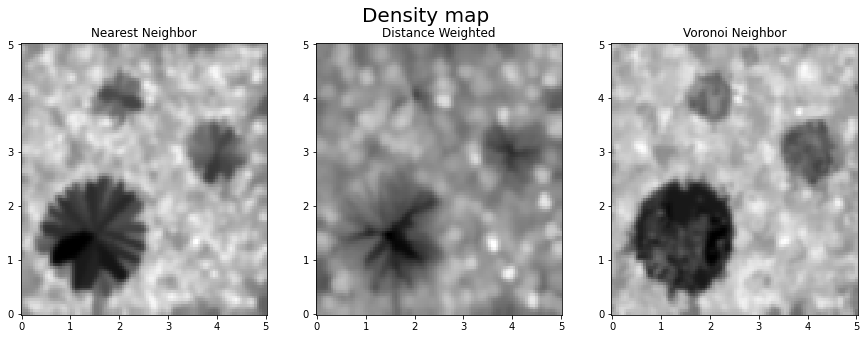

In [12]:
# the final density maps for each interpolation method

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))

ax1.pcolormesh(ixm,iym,blurred_m[0],cmap='gray'); ax1.set_title("Nearest Neighbor")
ax2.pcolormesh(ixm,iym,blurred_m[1],cmap='gray'); ax2.set_title("Distance Weighted")
ax3.pcolormesh(ixm,iym,blurred_m[2],cmap='gray'); ax3.set_title("Voronoi Neighbor")

fig.suptitle("Density map",fontsize = 20)
plt.show()

<a id='threshmulti'></a>
#### Thresholding

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

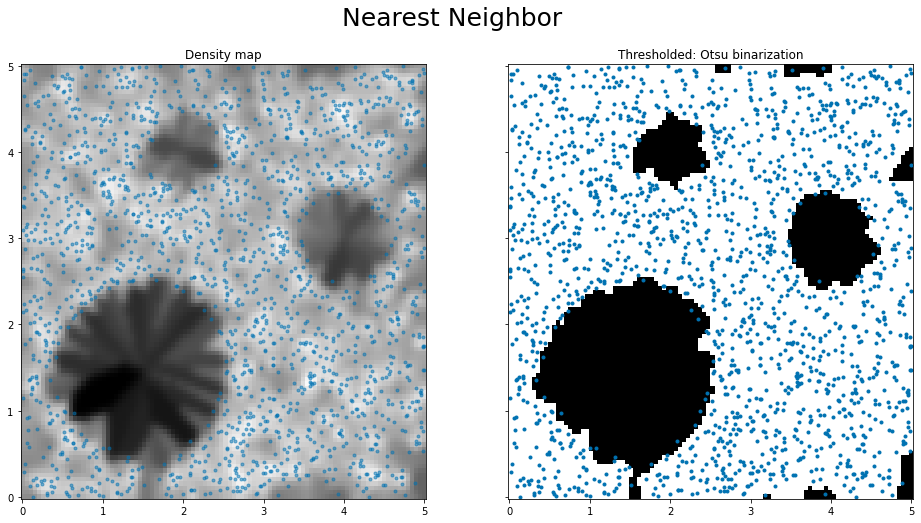

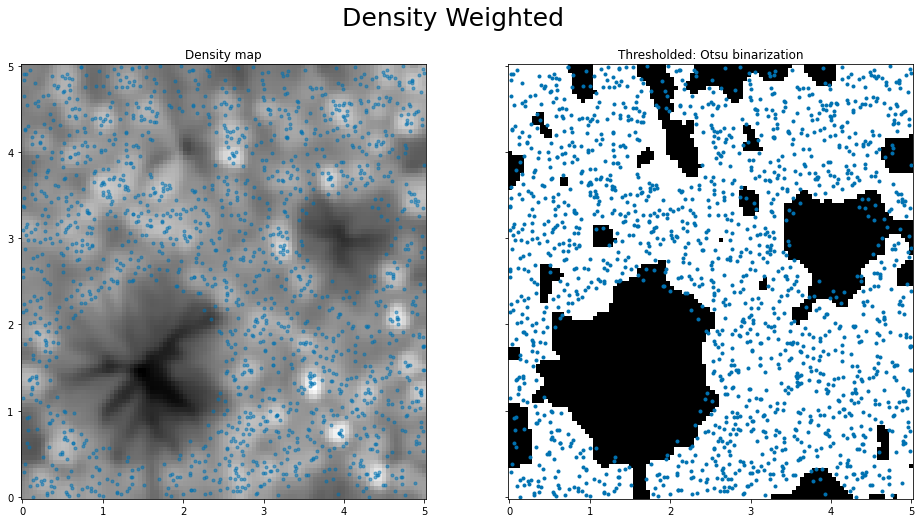

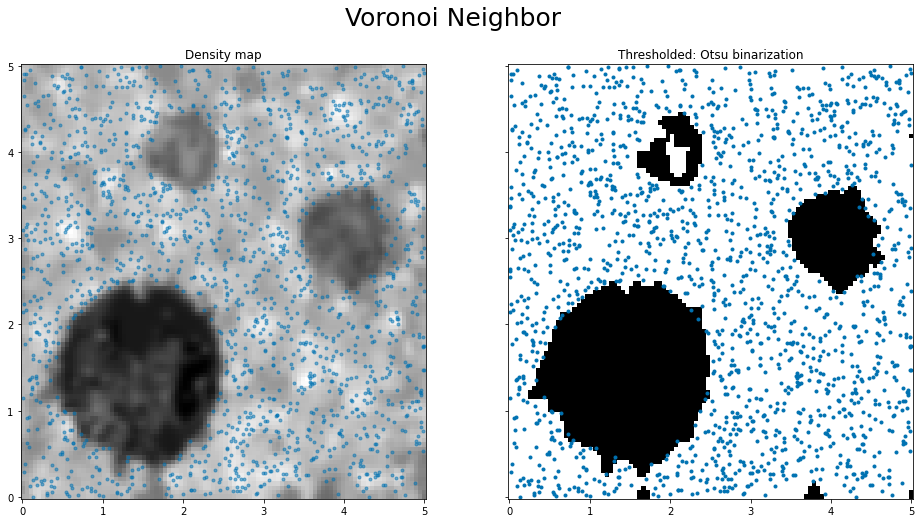

In [13]:
for image, title in zip(blurred_m,["Nearest Neighbor","Density Weighted","Voronoi Neighbor"]):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharex=True,sharey=True)
    fig.suptitle(title)
    
    ax1.pcolormesh(ixm,iym,image,cmap='gray')
    ax1.plot(x_m,y_m,'.',alpha = 0.5)
    ax1.set_title('Density map')

    ax2.pcolormesh(ixm,iym,binary, cmap='gray')
    ax2.plot(x_m,y_m,'.')
    ax2.set_title('Thresholded: Otsu binarization')

plt.show()

<a id = 'sdss'></a>

## SDSS Data

Now that we know the algorithm has mediocre to bad performance on multiple voids, let's try it on some actual data!

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

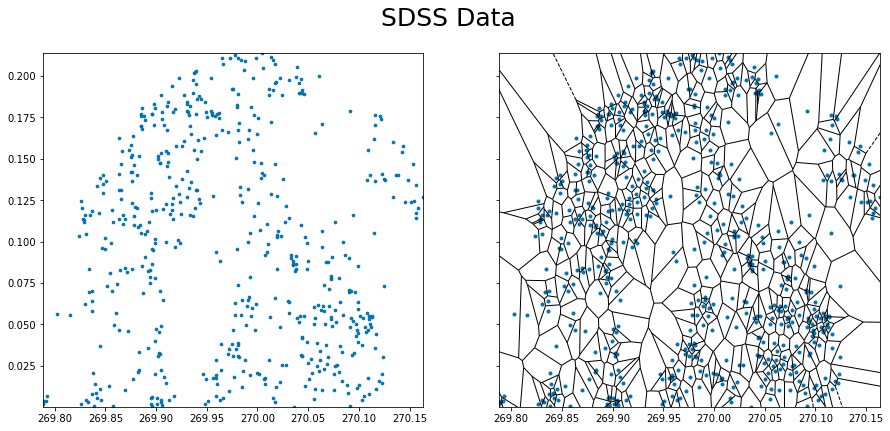

In [14]:
data = ascii.read("void_dat_test.csv") # from SDSS SkyServer

ra = data["ra"][np.where(data["dec"]>0)] # there's data below what is cut off by the Milky Way
dec = data["dec"][np.where(data["dec"]>0)] # the algorithm works with it, but it identifies the blank where the Milk Way is as a void

points_d = np.stack((ra,dec),axis=-1)

# plot the data 
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6.5),sharex=True,sharey=True)

ax1.scatter(ra,dec, s = 7)
voronoi_plot_2d(Voronoi(points_d), ax=ax2, point_size=6, show_points=True, show_vertices=False)

fig.suptitle("SDSS Data")
ax1.set_xlim(min(ra), max(ra))
ax1.set_ylim(min(dec), max(dec))
plt.show()

<a id = 'interpsdss'></a>

In [15]:
blurred_d, unblurred_d, ixd, iyd = voids.interpolater(points_d, 'all', grid = 100)

<a id = 'denssdss'></a>

#### Density maps

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

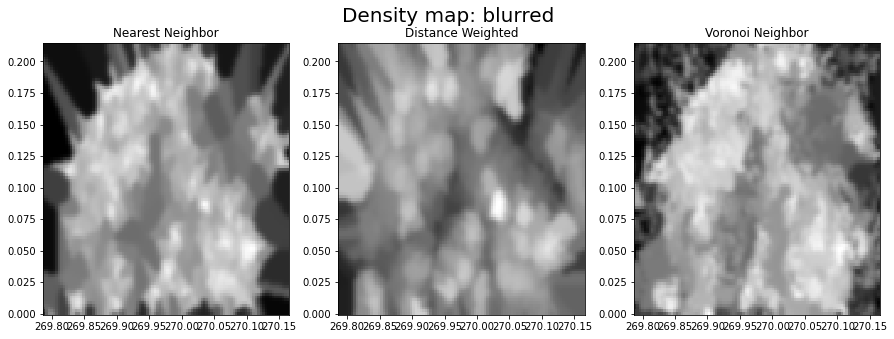

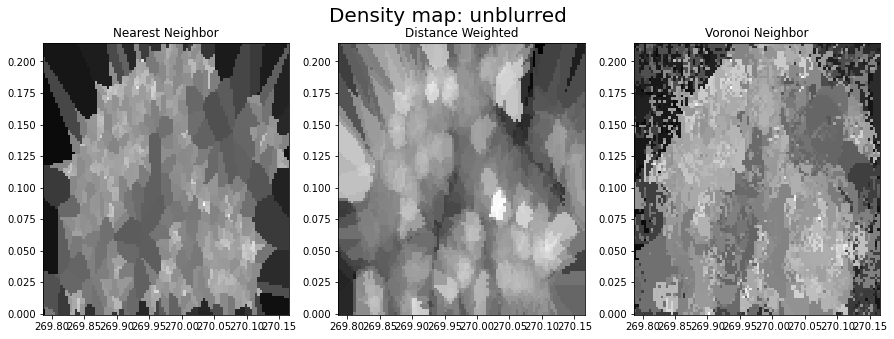

In [16]:
# the final density maps for each interpolation method

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))

ax1.pcolormesh(ixd,iyd,blurred_d[0],cmap='gray'); ax1.set_title("Nearest Neighbor")
ax2.pcolormesh(ixd,iyd,blurred_d[1],cmap='gray'); ax2.set_title("Distance Weighted")
ax3.pcolormesh(ixd,iyd,blurred_d[2],cmap='gray'); ax3.set_title("Voronoi Neighbor")

fig.suptitle("Density map: blurred",fontsize = 20)
plt.show()

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))

ax1.pcolormesh(ixd,iyd,unblurred_d[0],cmap='gray'); ax1.set_title("Nearest Neighbor")
ax2.pcolormesh(ixd,iyd,unblurred_d[1],cmap='gray'); ax2.set_title("Distance Weighted")
ax3.pcolormesh(ixd,iyd,unblurred_d[2],cmap='gray'); ax3.set_title("Voronoi Neighbor")

fig.suptitle("Density map: unblurred",fontsize = 20)
plt.show()

<a id = 'threshsdss'></a>

#### Thresholding

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>

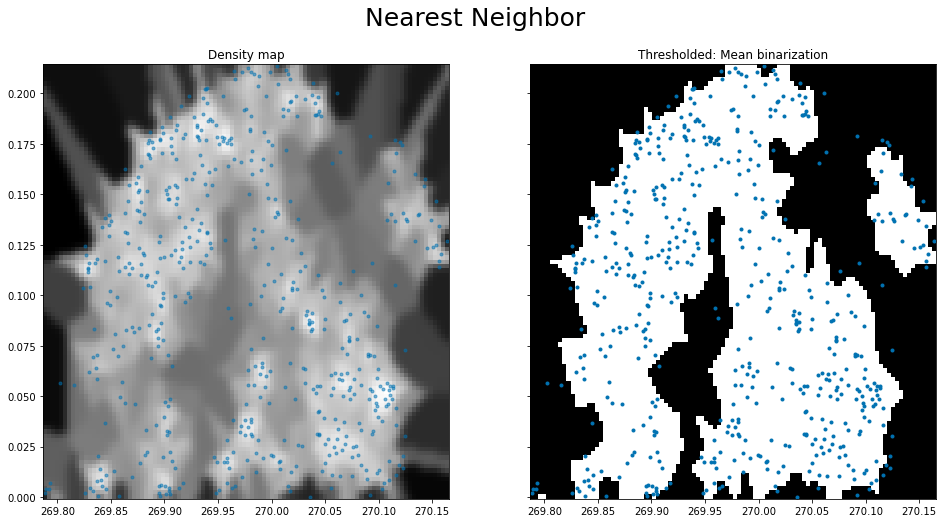

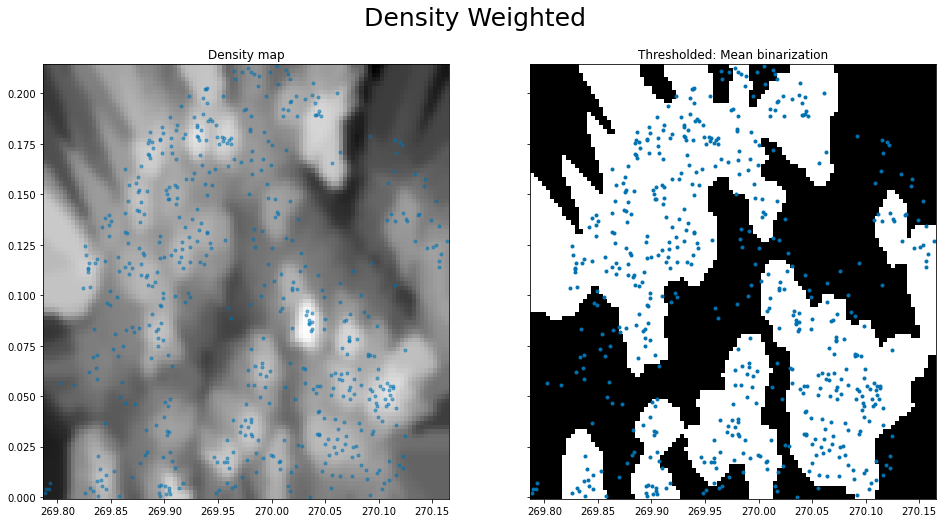

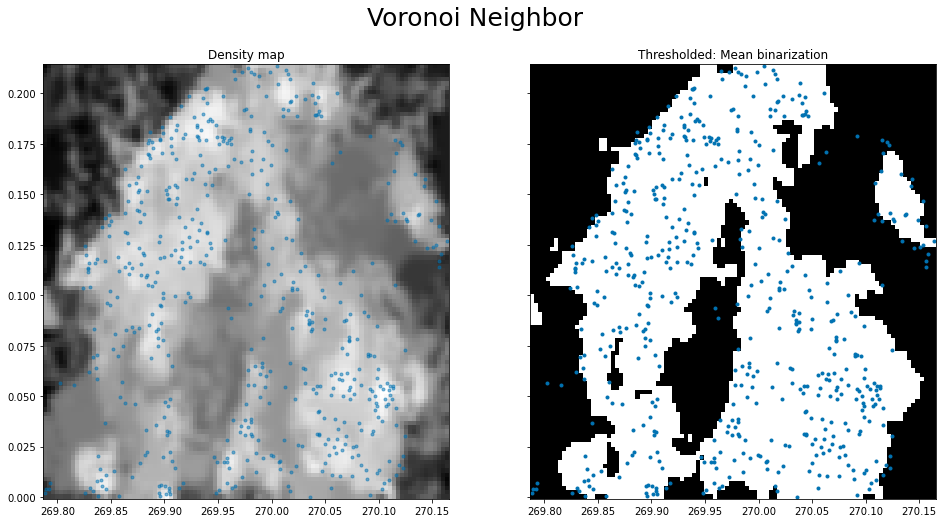

In [17]:
for image, title in zip(blurred_d,["Nearest Neighbor","Density Weighted","Voronoi Neighbor"]):
    thresh = filters.threshold_mean(image)
    binary = image > thresh

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharex=True,sharey=True)
    fig.suptitle(title)
    
    ax1.pcolormesh(ixd,iyd,image,cmap='gray')
    ax1.plot(ra,dec,'.',alpha = 0.5)
    ax1.set_title('Density map')

    ax2.pcolormesh(ixd,iyd,binary, cmap='gray')
    ax2.plot(ra,dec,'.')
    ax2.set_title('Thresholded: Mean binarization')

plt.show()

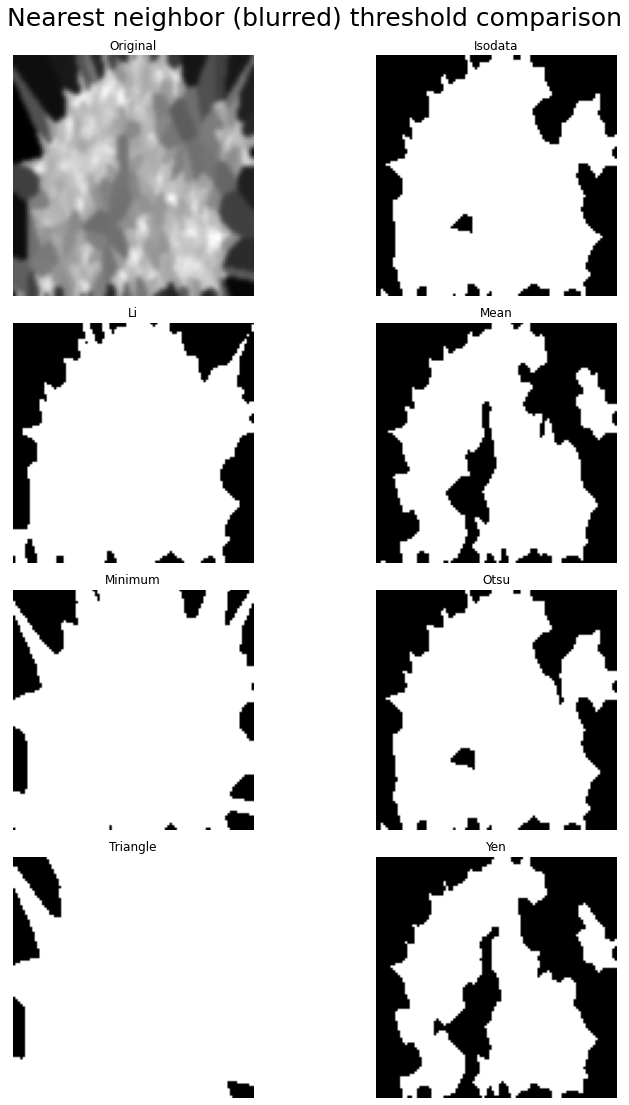

In [18]:
img = blurred_d[0]

fig, ax = filters.try_all_threshold(np.rot90(img.T), figsize=(12, 15), verbose=False)

fig.suptitle("Nearest neighbor (blurred) threshold comparison",y=1.02)

plt.show()

<font size = '2'><a href = '#top' style="text-decoration:none"> Return to top ↑ </a></font>